---
# Proyecto UT5: Predicción del tipo de un pokémon a partir de su imagen

---
## Imports

In [277]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import shutil

---
## Data

### Preparación del dataset.

Podemos observar que el dataframe incluye:
* __Name__: El nombre del pokemon.
* __Type1__: El tipo principal del pokemon.
* __Type2__: El tipo secundario del pokemon. En principio no lo utilizaremos para nada para simplificar un poco las cosas.

In [278]:
dataframe = pd.read_csv("pokemon.csv")
dataframe

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


Creamos la variable clases, en la que guardaremos los diferentes tipos que hay.  
Comprobamos que se ajustan a los tipos reales y no hay ningún tipo de error.

In [279]:
clases = dataframe.Type1.unique()
clases

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

## Preparación de las imagenes.

Para empezar guardamos el path de la imagen del pokemon en el dataframe. (Código sacado de internet).  
Así ya tenemos guardado cada pokémon con la dirección de su respectiva imagen.

In [280]:
# import the modules
images = []
# get the path or directory
folder_dir = "images/images"
for image in os.listdir(folder_dir):
    # check if the image end swith png or jpg or jpeg
    if (image.endswith(".png") or image.endswith(".jpg") or image.endswith(".jpeg")):
        # display
        images.append(image)


Como las imágenes no están todas en el mismo formato, hay que tener cuidado y estar pendiente de si se guardan en un formato u otro, por eso mismo vamos a guardarnos también su formato.

In [281]:
paths = []
format = []
for d in dataframe.Name:
    for i in images:
        if (d + ".png" == i or d + ".jpg" == i):
            paths.append("images/images/"+i)
            if (d + ".png" == i):
                format.append(".png")
            else:
                format.append(".jpg")

Así pues ahora tenemos guardado el __Path__ de la imagen del pokemon y también el __formato__ en el que está guardado.

In [282]:
dataframe = dataframe.assign(ImgPath=paths)
dataframe = dataframe.assign(Format=format)

dataframe

,Name,Type1,Type2,ImgPath,Format
0,bulbasaur,Grass,Poison,images/images/bulbasaur.png,.png
1,ivysaur,Grass,Poison,images/images/ivysaur.png,.png
2,venusaur,Grass,Poison,images/images/venusaur.png,.png
3,charmander,Fire,NaN,images/images/charmander.png,.png
4,charmeleon,Fire,NaN,images/images/charmeleon.png,.png
...,...,...,...,...,...
804,stakataka,Rock,Steel,images/images/stakataka.jpg,.jpg
805,blacephalon,Fire,Ghost,images/images/blacephalon.jpg,.jpg
806,zeraora,Electric,NaN,images/images/zeraora.jpg,.jpg
807,meltan,Steel,NaN,images/images/meltan.jpg,.jpg


Ahora utilizamos las librerías __os__ y __shutil__ para crear el directorio necesario para la importación de keras.  

Podemos ajustar los ifs para elegir solo los tipos que queramos.  

Crearemos un directorio _train/train_ donde guardaremos todos los pokemons separados para clase que utilizaremos para entrenar el modelo.

In [283]:
shutil.rmtree("train")
os.mkdir("train")

for clase in clases:
    # if (clase == "Water" or clase == "Fire" or clase == "Grass"):
        os.mkdir("train/" + clase)

for (path, type, name, format) in zip(dataframe.ImgPath, dataframe.Type1, dataframe.Name, dataframe.Format):
    # if (type == "Water" or type == "Fire" or type == "Grass"):
        shutil.copyfile(path, "train/" + type + "/" + name + format)

Finalmente cargamos las imagenes ya organizadas por tipos.  
Dividimos los datos en _training_ y en _validation_.

In [284]:
pokemons_train = tf.keras.utils.image_dataset_from_directory(directory="train", subset="training", validation_split=0.2, seed=612)
pokemons_val = tf.keras.utils.image_dataset_from_directory(directory="train", subset="validation", validation_split=0.2, seed=612)

Found 809 files belonging to 18 classes.
Using 648 files for training.
Found 809 files belonging to 18 classes.
Using 161 files for validation.


Reasignamos la variable _clases_ para que guarde los tipos en el orden correcto.

In [285]:
clases = pokemons_train.class_names
clases

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

---
## Modelo

Ajustamos el numero de clases según la cantidad de clases que detecte en los datos (util si hemos jugado con los ifs para coger diferentes tipos).

In [286]:
num_clases = len(pokemons_train.class_names)

Preparamos el entrenamiento del modelo. Incluye: 

* Capa __Dropout__, para evitar un poco el sobreaprendizaje.
* Capa __Convulacional 2D__, para el tratamiento de imágenes.
* Capa __MaxPooling 2D__, también para el tratamiento de imágenes.
* Capa __Flatten__, para pasar de las capas de tratamiento de imagen a otras.
* Capa __Dense__, para el tratamiento de datos en general.

In [287]:
inputs = tf.keras.Input(shape=(256,256,3))
x = tf.keras.layers.Dropout(0.1)(inputs)
x = tf.keras.layers.Conv2D(4, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(16, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(256, 5, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(512, 7, activation="relu")(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)

x = tf.keras.layers.Dense(num_clases, activation="softmax")(x)

model = tf.keras.Model(inputs, x)

Compilamos el modelo:
* Optimizador __Adam__, un modelo eficiente y básico para Redes Neuronales.
* __Sparse Categorical Crossentropy__, para cuando hay varias clases diferentes para clasificar.


In [288]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy'])

Mostramos un pequeño resumen del modelo que hemos hecho, para comprobar.

In [289]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 dropout_6 (Dropout)         (None, 256, 256, 3)       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 254, 254, 4)       112       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 127, 127, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 125, 125, 16)      592       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                     

Finalmente hacemos fit del modelo.  
Guardamos un historial para poder visualizar cómo ha ido el entrenamiento.

Asignamos como datos de entrenamiento el _pokemons_train_ y como datos de validación el _pokemons_val_

In [290]:
history = model.fit(
    pokemons_train,
    validation_data = pokemons_val,
    epochs=20
)

Epoch 1/20
21/21 [==============================] - 19s 866ms/step - loss: 63.6053 - sparse_categorical_accuracy: 0.0880 - val_loss: 2.8236 - val_sparse_categorical_accuracy: 0.1429
Epoch 2/20
21/21 [==============================] - 18s 841ms/step - loss: 2.7686 - sparse_categorical_accuracy: 0.1420 - val_loss: 2.8311 - val_sparse_categorical_accuracy: 0.0870
Epoch 3/20
21/21 [==============================] - 18s 836ms/step - loss: 2.8350 - sparse_categorical_accuracy: 0.1373 - val_loss: 2.8462 - val_sparse_categorical_accuracy: 0.0994
Epoch 4/20
21/21 [==============================] - 18s 851ms/step - loss: 2.7540 - sparse_categorical_accuracy: 0.1420 - val_loss: 2.7609 - val_sparse_categorical_accuracy: 0.1366
Epoch 5/20
21/21 [==============================] - 17s 830ms/step - loss: 2.6613 - sparse_categorical_accuracy: 0.1682 - val_loss: 2.8037 - val_sparse_categorical_accuracy: 0.1242
Epoch 6/20
21/21 [==============================] - 18s 862ms/step - loss: 2.5753 - sparse_cat

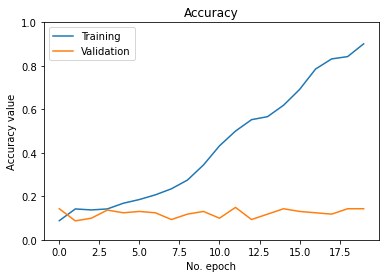

In [291]:
plt.plot(history.history['sparse_categorical_accuracy'], label='Training')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.ylim(0,1)
plt.show()

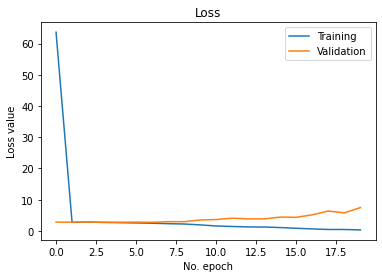

In [292]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

Podemos observar cómo el accuracy de los datos de _training_ van mejorando poco a poco mientras que los datos de _validation_ se quedan estancados en unos valores relativamente bajos.  
Teniendo en cuenta que hay 18 clases y su accuracy ronda el 11-15% podemos afirmar que hay cierto aprendizaje, ya que en caso de no haberlo este porcentaje debería rondar el 6%; pero no el suficiente.  
También observamos que cuanto más sobreaprende el _training_ más bajo da el accuracy del _validation_.

---
## Predicciones

Ahora, con el modelo entrenado, vamos a tratar de hacer predicciones individuales para comprobar el funcionamiento.  
Se podría también tratar de predecir cualquier tipo de imagen, por ejemplo un Digimon, y de ver qué tipo le asignaría con los datos recopilados; sin embargo vamos a introducir pokemons reales (que ya tenemos guardados) para ver si se ajusta o no a lo real.

En _pok_name_ introduciremos el nombre del pokemon que queremos predecir.

C:\Users\BDIA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


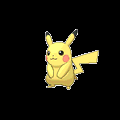

In [293]:
pok_name = "pikachu"
pok = dataframe.loc[(dataframe.Name == pok_name)]
tf.keras.utils.load_img(pok.ImgPath.item())

Crearemos un directorio _test_ para que podamos usar correctamente el sistema de importación de keras.

In [294]:
shutil.rmtree("test") # Si ya existe el directorio lo borramos para que no haya errores
os.mkdir("test")
os.mkdir("test/test")
shutil.copyfile(pok.ImgPath.item(), "test/test/" + pok.Name.item() + pok.Format.item())

'test/test/pikachu.png'

Finalmente predecimos el tipo de pokémon.  

In [295]:
pokemons_test = tf.keras.utils.image_dataset_from_directory(directory="test")
predictions = model.predict(pokemons_test)


Found 1 files belonging to 1 classes.


Primero mostraremos el tipo al que es más probable que pertenezca.  

In [296]:
print("El tipo PREDECIDO es:", clases[(predictions.argmax())])

El tipo PREDECIDO es: Water


Luego mostraremos las probabilidades de cada tipo.  

In [297]:
print("Las probabilidades de que pertenezca a cada tipo son:")
c = 0
for p in predictions[0]:
    print("\t", clases[c], ": %.1f" % (p*100))
    c += 1

Las probabilidades de que pertenezca a cada tipo son:
	 Bug : 1.6
	 Dark : 0.0
	 Dragon : 0.0
	 Electric : 8.3
	 Fairy : 0.0
	 Fighting : 0.0
	 Fire : 0.0
	 Flying : 0.0
	 Ghost : 0.0
	 Grass : 0.0
	 Ground : 0.0
	 Ice : 0.0
	 Normal : 39.4
	 Poison : 0.0
	 Psychic : 0.0
	 Rock : 0.0
	 Steel : 0.0
	 Water : 50.7


Finalmente mostraremos su tipo real.

In [298]:
print("El tipo REAL es:", pok.Type1.item())

El tipo REAL es: Electric
